# Активы МСП

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import itertools
from pmdarima import auto_arima

from parser.loans_volume_msp import get_measures, get_loans_volume_msp_df
from parser.new_loans_msp import get_new_loans_msp_df
from data_transform.transform_df import transform_df_to_format

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

In [15]:
# метрика точности модели
# actual - фактические данные
# predict - предсказанные данные
def mape( actual , predict ): 
    actual, predict = np.array(actual), np.array(predict)
    actual_safe = np.where(actual == 0, 1e-10, actual)
    return np.mean(np.abs((actual - predict) / actual_safe))*100

# разделение данных на тренировочную и тестовую выборки по указанной дате
# dataframe - данные для деления
# date - дата, по которой происходит деление на выборки 
def divide_data(dataframe: pd.DataFrame, date: str):
    split_index = dataframe.index[dataframe['date'] == date]
    train_size = split_index[0]
    test_size = len(dataframe) - train_size
    train = dataframe[dataframe['date']<date]
    test = dataframe[dataframe['date']>=date]
    # Делаем из датафреймов серии
    train_data = train.copy()
    train_data.set_index(keys='date', drop=True, inplace=True)
    train_data = train_data.squeeze(axis=1)
    test_data = test.copy()
    test_data.set_index(keys='date', drop=True, inplace=True)
    test_data = test_data.squeeze(axis=1)
    return train_data, test_data

# Отрисовка графика данных и их прогноза с указанием названия прогнозируемой величины
# dataframe - исходные данные 
# predict - спрогнозированные данные
# name - название прогнозируемой величины
def show_plot(dataframe: pd.DataFrame, predict: pd.DataFrame, name, plt_title = 'Российская Федерация'):
    columns = list(dataframe)
    plt.figure(figsize=(12, 4))
    plt.plot(dataframe[columns[0]], dataframe[columns[1]].values/1e6)
    plt.plot(predict/1e6)
    plt.xlabel('Дата')
    plt.ylabel(name + ', трлн руб.')
    plt.title(plt_title)
    plt.grid(True)
    plt.show()

# Получение прогноза с помощью модели SARIMAX
# dataframe - исходные данные
# start_date - дата, от которой строится прогноз 
# last_predict_date - дата, до которой строится прогноз
# ct_trend - необходимо ли искусственно выпрямить тренд (True задает линейный тренд)
# custom - подбираем автоматически парамеры для настройки SARIMAX или передаем уже подобранные значения season_ord и custom_pdq
def get_data_predict(dataframe: pd.DataFrame, start_date: str, last_predict_date: str, ct_trend=True, custom=False, season_ord = (1,1,1,12), custom_pdq = (1,1,1)):
    model_trend = None
    if ct_trend :
        model_trend = 'ct'
    train_data, test_data = divide_data(dataframe, start_date)
    # Подбор параметров
    if custom :
        s_ord = season_ord
        pdq = custom_pdq
    else :
        parameter_search = auto_arima(train_data, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 1,
                                  seasonal = True, d = None, D = 1, trace = False, error_action ='ignore',
                                  suppress_warnings = True,  stepwise = True) 
        s_ord = parameter_search.seasonal_order
        pdq = parameter_search.order
    # ОБУЧЕНИЕ МОДЕЛИ
    model = SARIMAX(train_data, order=pdq, seasonal_order=s_ord, trend=model_trend , measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
    model_fit = model.fit()
    # Получение предсказания
    pred = model_fit.get_prediction(start=start_date, end=last_predict_date, dynamic=False)
    predict = pred.predicted_mean
    test_pred = predict[0:len(test_data)]
    mp = mape(test_data.values, test_pred.values)
    return predict, mp
    

# Региональный разрез

In [16]:
# Получаем список регионов
regions = get_measures()

In [ ]:
for key,value in regions.items():
    print(key, ' - ', value)


## Объем кредитов, выданных МСП:

Центральный федеральный округ 

Спрогнозированные значения:
2023-05-01    371039.231388
2023-06-01    502458.164847
2023-07-01    436111.815804
2023-08-01    433052.704884
2023-09-01    507627.615125
2023-10-01    481208.246432
2023-11-01    463448.473738
2023-12-01    668825.090383
2024-01-01    395196.549679
2024-02-01    430604.521161
2024-03-01    450129.096025
2024-04-01    465767.609097
2024-05-01    393481.363717
2024-06-01    505014.981196
2024-07-01    496669.725478
2024-08-01    485955.634490
2024-09-01    571289.718113
2024-10-01    511351.544392
2024-11-01    500548.169825
2024-12-01    712142.175946
2025-01-01    409917.840383
2025-02-01    457011.320531
2025-03-01    524144.750502
2025-04-01    539897.847531
2025-05-01    457509.512179
2025-06-01    579067.303892
2025-07-01    539747.875604
2025-08-01    532620.049264
2025-09-01    611847.433668
2025-10-01    569109.870900
2025-11-01    554201.516305
2025-12-01    762079.543861
2026-01-01    474464.406955
2026-02-01    51

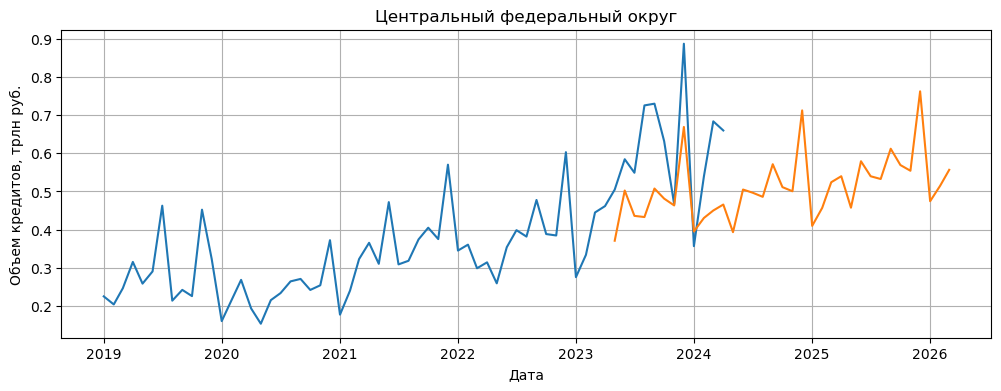

Северо-Западный федеральный округ 

Спрогнозированные значения:
2023-05-01     96355.484285
2023-06-01    130035.800545
2023-07-01     98039.816496
2023-08-01     99955.006060
2023-09-01     98626.311125
2023-10-01    249941.466126
2023-11-01    117604.617861
2023-12-01    138492.730449
2024-01-01     83593.958607
2024-02-01    110188.349468
2024-03-01    103635.778497
2024-04-01    102789.783631
2024-05-01     81341.445729
2024-06-01    114868.051766
2024-07-01     90370.765732
2024-08-01     95352.800571
2024-09-01     91747.692820
2024-10-01    293042.868820
2024-11-01    108277.823252
2024-12-01    120834.856383
2025-01-01     73892.735036
2025-02-01     84483.222449
2025-03-01    104994.712138
2025-04-01    104120.808201
2025-05-01     82366.264074
2025-06-01    115647.957242
2025-07-01     86060.090335
2025-08-01     88967.505363
2025-09-01     84033.703267
2025-10-01    267869.418061
2025-11-01    103378.329616
2025-12-01    117775.885213
2026-01-01     67594.036979
2026-02-01  

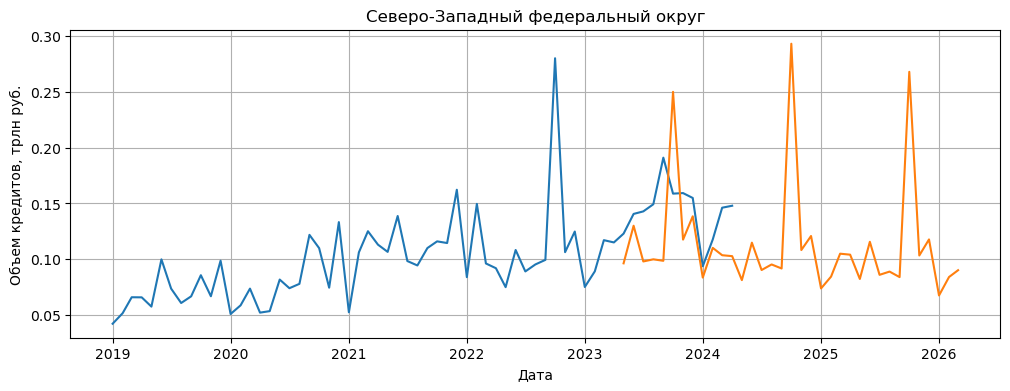

Южный федеральный округ 

Спрогнозированные значения:
2023-05-01     89977.510540
2023-06-01    117933.649469
2023-07-01    119018.271121
2023-08-01    128287.918132
2023-09-01    127550.080782
2023-10-01    113290.477490
2023-11-01    111649.786855
2023-12-01    152522.284846
2024-01-01    102612.214372
2024-02-01    116575.182141
2024-03-01    141917.414397
2024-04-01    131071.420693
2024-05-01    115065.688121
2024-06-01    144363.714558
2024-07-01    146779.371727
2024-08-01    156208.348036
2024-09-01    155980.781298
2024-10-01    139526.181881
2024-11-01    138529.105239
2024-12-01    180846.318546
2025-01-01    129759.958187
2025-02-01    144539.782676
2025-03-01    174372.094759
2025-04-01    161553.146965
2025-05-01    145763.676172
2025-06-01    175088.989319
2025-07-01    177534.993431
2025-08-01    187324.734759
2025-09-01    187358.968511
2025-10-01    171929.047697
2025-11-01    171156.169063
2025-12-01    213471.671908
2026-01-01    163122.717669
2026-02-01    178077.8

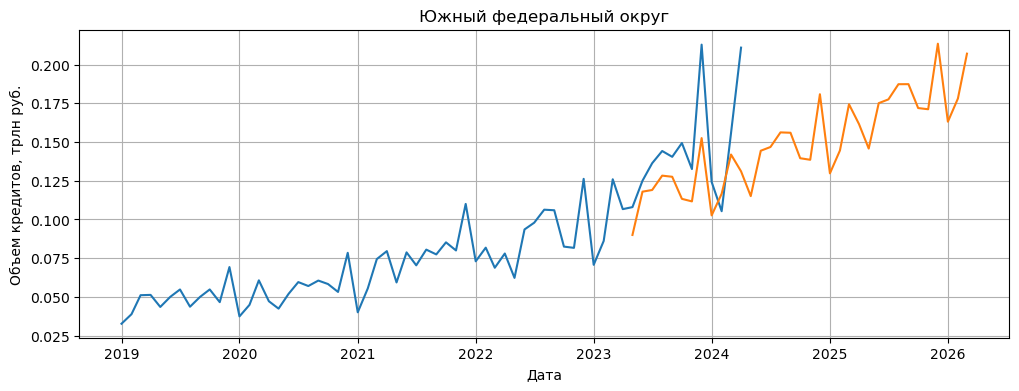

Северо-Кавказский федеральный округ 

Спрогнозированные значения:
2023-05-01    15160.947069
2023-06-01    31471.665260
2023-07-01    20197.408183
2023-08-01    23189.611591
2023-09-01    22028.276725
2023-10-01    19629.076925
2023-11-01    20149.386213
2023-12-01    31038.869463
2024-01-01    17971.360448
2024-02-01    18731.632991
2024-03-01    24408.235278
2024-04-01    22180.053422
2024-05-01    19295.720950
2024-06-01    36471.684274
2024-07-01    24568.891723
2024-08-01    27818.003909
2024-09-01    25942.713759
2024-10-01    23950.147364
2024-11-01    24516.748499
2024-12-01    35844.804293
2025-01-01    22442.077215
2025-02-01    23205.238510
2025-03-01    29333.316958
2025-04-01    26848.351856
2025-05-01    24204.875788
2025-06-01    41246.571926
2025-07-01    29554.445335
2025-08-01    32809.763019
2025-09-01    31164.863362
2025-10-01    29143.929125
2025-11-01    29765.369915
2025-12-01    41057.682709
2026-01-01    27797.890830
2026-02-01    28625.914114
2026-03-01    34

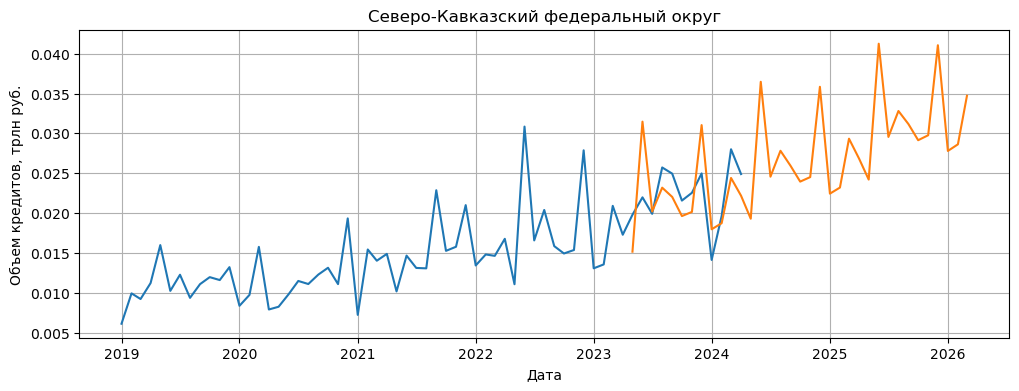

Приволжский федеральный округ 

Спрогнозированные значения:
2023-05-01    147281.469411
2023-06-01    186148.288920
2023-07-01    172918.363918
2023-08-01    173684.970690
2023-09-01    190118.737056
2023-10-01    186833.838954
2023-11-01    198043.146874
2023-12-01    228909.922936
2024-01-01    140022.621827
2024-02-01    171007.871025
2024-03-01    213064.350268
2024-04-01    194531.751775
2024-05-01    162310.515719
2024-06-01    199638.169402
2024-07-01    191535.194555
2024-08-01    194915.706507
2024-09-01    209688.559878
2024-10-01    203843.562386
2024-11-01    216413.039478
2024-12-01    240382.258857
2025-01-01    163790.223013
2025-02-01    196011.835401
2025-03-01    256015.400443
2025-04-01    247699.358891
2025-05-01    207483.981372
2025-06-01    246820.854461
2025-07-01    234931.519980
2025-08-01    236710.680103
2025-09-01    253598.898384
2025-10-01    250651.092610
2025-11-01    262709.402705
2025-12-01    293346.982482
2026-01-01    206736.537495
2026-02-01    23

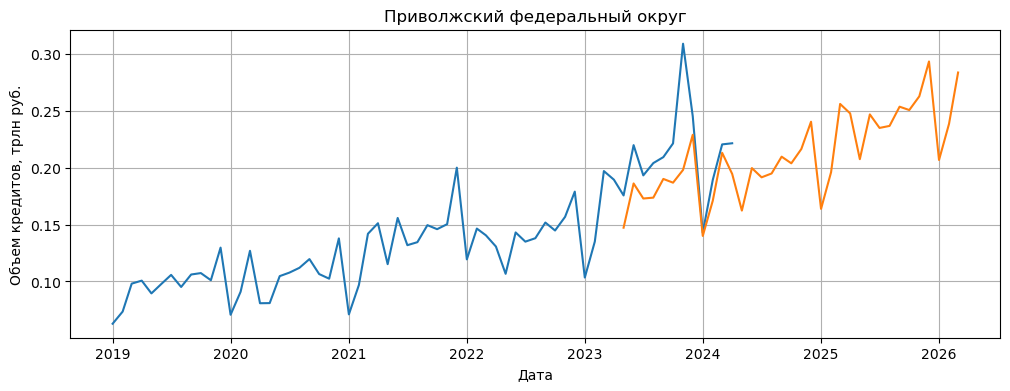

Уральский федеральный округ 

Спрогнозированные значения:
2023-05-01     88300.427520
2023-06-01    100078.287730
2023-07-01     98736.388980
2023-08-01    102838.076475
2023-09-01    108926.982575
2023-10-01    106395.361761
2023-11-01    108608.565736
2023-12-01    139130.099139
2024-01-01     97478.345393
2024-02-01    106562.846138
2024-03-01    173155.674219
2024-04-01    114303.688245
2024-05-01    114065.076930
2024-06-01    125905.031159
2024-07-01    124522.092728
2024-08-01    129916.247467
2024-09-01    137010.668811
2024-10-01    133461.042632
2024-11-01    138136.022407
2024-12-01    169261.431448
2025-01-01    127451.341969
2025-02-01    136592.665009
2025-03-01    216286.261793
2025-04-01    147719.792983
2025-05-01    148643.803827
2025-06-01    161048.585503
2025-07-01    160265.323673
2025-08-01    165808.559450
2025-09-01    173149.023682
2025-10-01    170529.193426
2025-11-01    174958.141745
2025-12-01    206465.308773
2026-01-01    165294.530545
2026-02-01    1750

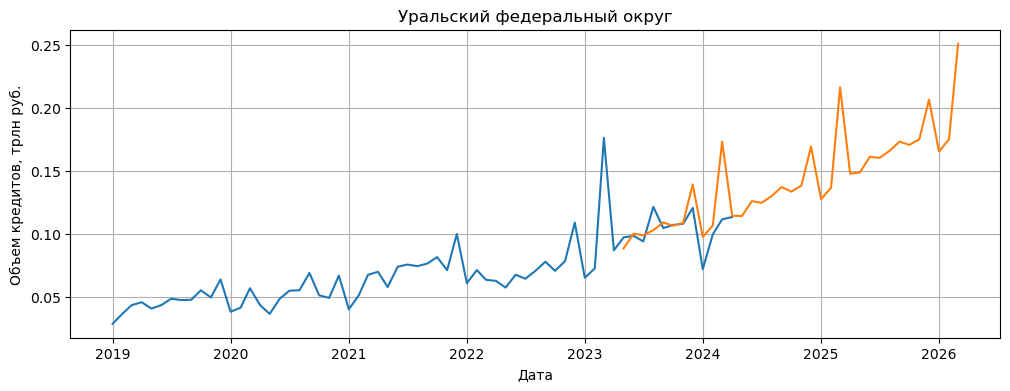

Сибирский федеральный округ 

Спрогнозированные значения:
2023-05-01     78523.578138
2023-06-01     97046.403075
2023-07-01     90379.184041
2023-08-01     95285.818329
2023-09-01    102896.522039
2023-10-01     86278.218459
2023-11-01     95498.060338
2023-12-01    114122.932290
2024-01-01     73093.806107
2024-02-01     86649.175240
2024-03-01     96974.131036
2024-04-01     98025.617543
2024-05-01     71755.748878
2024-06-01     93233.134722
2024-07-01     81618.320640
2024-08-01     91020.025987
2024-09-01     98562.531471
2024-10-01     76559.440436
2024-11-01     86876.579733
2024-12-01    103910.323336
2025-01-01     62123.806653
2025-02-01     73992.154516
2025-03-01     90464.534602
2025-04-01     94361.843501
2025-05-01     61763.289960
2025-06-01     81080.250429
2025-07-01     70831.937634
2025-08-01     77384.525458
2025-09-01     84114.488646
2025-10-01     63671.750704
2025-11-01     72655.337458
2025-12-01     89555.305999
2026-01-01     47262.555906
2026-02-01     590

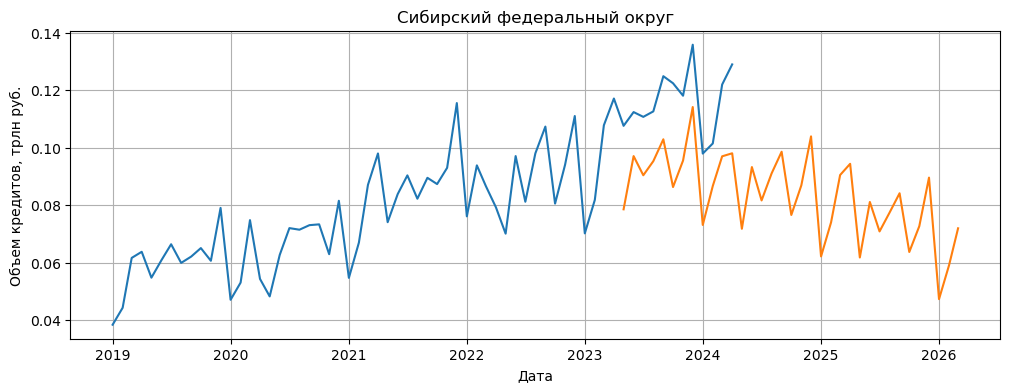

Дальневосточный федеральный округ 

Спрогнозированные значения:
2023-05-01     46447.408916
2023-06-01     52154.269146
2023-07-01     61497.643241
2023-08-01     63003.556539
2023-09-01     58917.314933
2023-10-01     56956.633446
2023-11-01     60060.192158
2023-12-01     83788.926344
2024-01-01     44152.672726
2024-02-01     55252.700689
2024-03-01     70973.591525
2024-04-01     74890.865245
2024-05-01     59053.740493
2024-06-01     67777.665697
2024-07-01     73105.000544
2024-08-01     74788.246526
2024-09-01     73428.984221
2024-10-01     70937.621976
2024-11-01     73053.048532
2024-12-01     97767.053640
2025-01-01     58739.129554
2025-02-01     69438.174802
2025-03-01     85287.362127
2025-04-01     89736.666152
2025-05-01     74001.797151
2025-06-01     82733.742395
2025-07-01     88342.664538
2025-08-01     90274.268428
2025-09-01     89018.291050
2025-10-01     86694.898335
2025-11-01     89040.220080
2025-12-01    113927.754052
2026-01-01     75055.985501
2026-02-01  

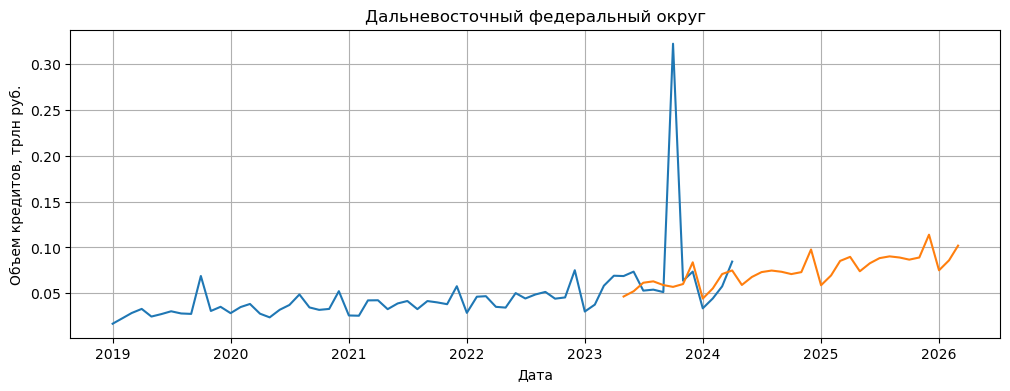

In [17]:
for key,value in regions.items():
    # Берем данные только по федеральным округам
    if key in [23, 42, 55, 64, 72, 87, 95, 106]:
        # получаем данные в формате датафрейма
        new_loans_volume_reg_df = get_new_loans_msp_df(2019, 2024, spikes_remove=False, measure_id=key)
        # определяем дату, до которой возьмем данные для обучения модели
        split_date = '2023-05'
        # определяем дату, до которой определяем прогноз
        last_predict_date = '2026-03'
        # Составляем прогноз
        predict, mp = get_data_predict(new_loans_volume_reg_df, split_date, last_predict_date)
        print(value, "\n")
        print("Спрогнозированные значения:")
        print(predict)
        print("MAPE = ", mp)
        # визуализируем данные и прогноз по ним
        show_plot(new_loans_volume_reg_df, predict, 'Объем кредитов', value)

Увеличим точность отдельных прогнозов:

Центральный федеральный округ 

Спрогнозированные значения:
2023-06-01    537435.088151
2023-07-01    493553.038098
2023-08-01    486889.670548
2023-09-01    563954.813630
2023-10-01    533272.290115
2023-11-01    518977.243281
2023-12-01    727897.389056
2024-01-01    451680.906014
2024-02-01    491747.134942
2024-03-01    522374.750824
2024-04-01    540634.703858
2024-05-01    539119.553598
2024-06-01    603384.357862
2024-07-01    603865.739560
2024-08-01    594521.528240
2024-09-01    682681.547491
2024-10-01    626204.464209
2024-11-01    619095.757534
2024-12-01    834495.478348
2025-01-01    536146.085089
2025-02-01    587114.066034
2025-03-01    658112.440973
2025-04-01    677763.703330
2025-05-01    699663.722612
2025-06-01    750989.475511
2025-07-01    732452.707770
2025-08-01    726522.941237
2025-09-01    811528.590428
2025-10-01    769487.497196
2025-11-01    761088.166930
2025-12-01    975534.278061
2026-01-01    689874.853734
2026-02-01    737780.553949
2026-03-01    79

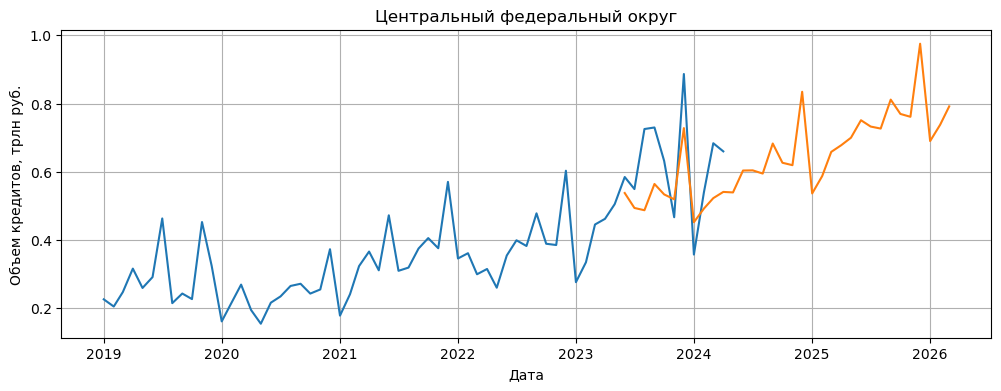

In [7]:
value = "Центральный федеральный округ"
key = 23
CFD_new_loans_msp_df = get_new_loans_msp_df(2019, 2024, spikes_remove=False, measure_id=key)
# print(df)

# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-06'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'

# Подбор параметров вручную
s_ord = (1,1,0,12)
pdq = (1,0,2)

# Составляем прогноз
predict, mp = get_data_predict(CFD_new_loans_msp_df, split_date, last_predict_date, custom = True,  season_ord = s_ord, custom_pdq = pdq )
print(value, "\n")
print("Спрогнозированные значения:")
print(predict)
print("MAPE = ", mp)


# визуализируем данные и прогноз по ним
show_plot(CFD_new_loans_msp_df, predict, 'Объем кредитов', value)

Северо-Западный федеральный округ 

Спрогнозированные значения:
2023-05-01    103294.184788
2023-06-01    133959.190399
2023-07-01    111357.084514
2023-08-01    111614.984858
2023-09-01    124020.853367
2023-10-01    159889.219362
2023-11-01    119122.074995
2023-12-01    150200.348596
2024-01-01     96240.485651
2024-02-01    126377.506746
2024-03-01    129048.942363
2024-04-01    122684.883831
2024-05-01    111867.974600
2024-06-01    141648.205168
2024-07-01    118896.367907
2024-08-01    118767.717734
2024-09-01    130893.677496
2024-10-01    166454.944904
2024-11-01    125397.867311
2024-12-01    156184.248659
2025-01-01    101935.827586
2025-02-01    131784.644907
2025-03-01    134168.697968
2025-04-01    127517.529274
2025-05-01    116413.755887
2025-06-01    145907.240671
2025-07-01    122868.740008
2025-08-01    122453.472078
2025-09-01    134292.843090
2025-10-01    169567.538697
2025-11-01    128223.899724
2025-12-01    158723.725903
2026-01-01    104188.753434
2026-02-01  

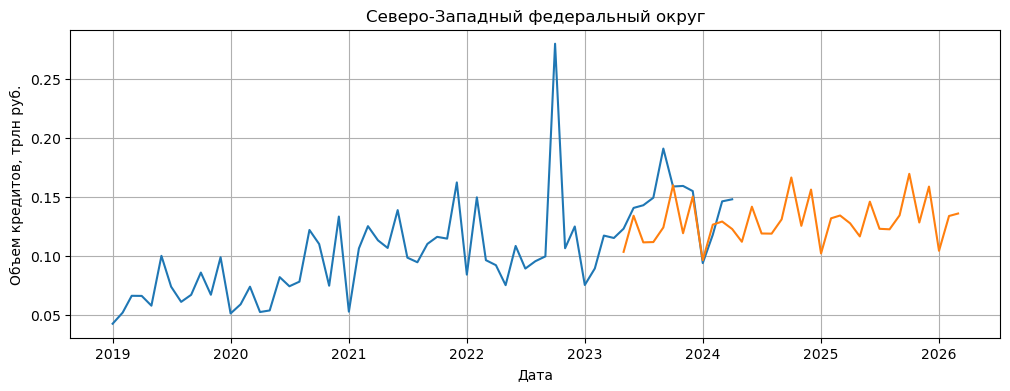

In [6]:
value = "Северо-Западный федеральный округ"
key = 42
NWFD_new_loans_msp_df = get_new_loans_msp_df(2019, 2024, spikes_remove=False, measure_id=key)
# print(df)
#print(NWFD_new_loans_msp_df[NWFD_new_loans_msp_df['date'] < '2023-02'])
# В строке 45 (2022-10-01   280032.0) - резкий скачок данных. Их необходимо искуственно сгладить
c_df = NWFD_new_loans_msp_df.copy()
c_df.at[45, 'msp_loans'] = c_df.at[45, 'msp_loans'] / 1.5

# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-05'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'

# Составляем прогноз
predict, mp = get_data_predict(c_df, split_date, last_predict_date)
print(value, "\n")
print("Спрогнозированные значения:")
print(predict)
print("MAPE = ", mp)

# визуализируем данные и прогноз по ним
show_plot(NWFD_new_loans_msp_df, predict, 'Объем кредитов', value)



Сибирский федеральный округ 

Спрогнозированные значения:
2023-06-01    109989.869196
2023-07-01     99198.950323
2023-08-01    107874.524356
2023-09-01    117394.788309
2023-10-01     96643.914432
2023-11-01    110380.162282
2023-12-01    129839.113909
2024-01-01     83840.792790
2024-02-01     97048.429935
2024-03-01    110850.413123
2024-04-01    110463.139216
2024-05-01    104313.805072
2024-06-01    115513.639906
2024-07-01    100594.912101
2024-08-01    115298.378056
2024-09-01    124451.339266
2024-10-01     98847.427009
2024-11-01    112230.283190
2024-12-01    129549.653197
2025-01-01     87287.773435
2025-02-01     99105.236491
2025-03-01    122026.917940
2025-04-01    128865.029818
2025-05-01    119953.389192
2025-06-01    124234.381543
2025-07-01    112287.413227
2025-08-01    122192.329674
2025-09-01    131444.210009
2025-10-01    109375.174263
2025-11-01    122851.543881
2025-12-01    141634.115388
2026-01-01     96340.540640
2026-02-01    109052.636569
2026-03-01    1248

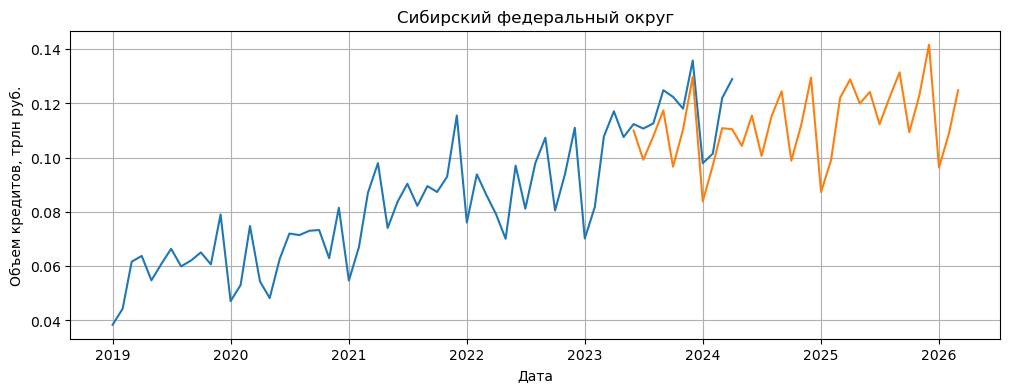

In [8]:
value = "Сибирский федеральный округ"
key = 95
SibFD_new_loans_msp_df = get_new_loans_msp_df(2019, 2024, spikes_remove=False, measure_id=key)
# print(df)

# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-06'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'

# Составляем прогноз
predict, mp = get_data_predict(SibFD_new_loans_msp_df, split_date, last_predict_date, ct_trend=False)
print(value, "\n")
print("Спрогнозированные значения:")
print(predict)
print("MAPE = ", mp)

# визуализируем данные и прогноз по ним
show_plot(SibFD_new_loans_msp_df, predict, 'Объем кредитов', value)

## Объем задолженности МСП:

Центральный федеральный округ 

Спрогнозированные значения:
2023-05-01    5.044569e+06
2023-06-01    5.131885e+06
2023-07-01    4.806854e+06
2023-08-01    5.067086e+06
2023-09-01    5.318043e+06
2023-10-01    5.425869e+06
2023-11-01    5.633609e+06
2023-12-01    5.890985e+06
2024-01-01    5.931387e+06
2024-02-01    6.259793e+06
2024-03-01    6.414810e+06
2024-04-01    6.654026e+06
2024-05-01    6.849630e+06
2024-06-01    6.984319e+06
2024-07-01    6.706822e+06
2024-08-01    7.014753e+06
2024-09-01    7.313569e+06
2024-10-01    7.469418e+06
2024-11-01    7.725343e+06
2024-12-01    8.031065e+06
2025-01-01    8.119977e+06
2025-02-01    8.497055e+06
2025-03-01    8.700906e+06
2025-04-01    8.989119e+06
2025-05-01    9.233882e+06
2025-06-01    9.417892e+06
2025-07-01    9.189880e+06
2025-08-01    9.547456e+06
2025-09-01    9.896081e+06
2025-10-01    1.010190e+07
2025-11-01    1.040796e+07
2025-12-01    1.076398e+07
2026-01-01    1.090335e+07
2026-02-01    1.133105e+07
2026-03-01    1.158568

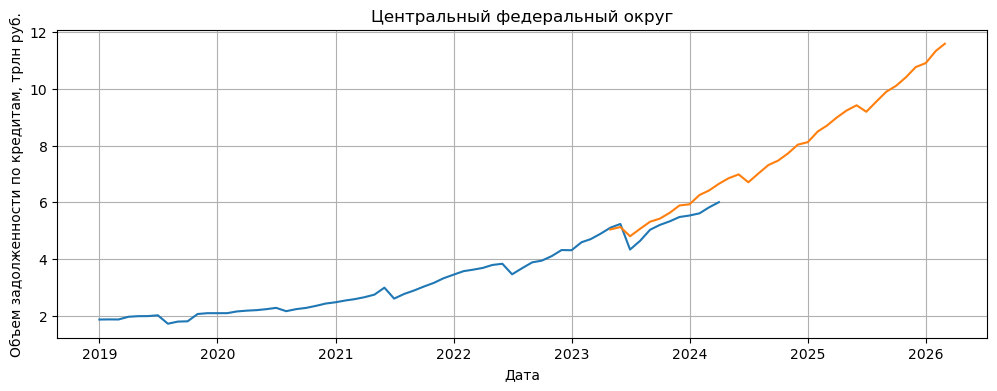

Северо-Западный федеральный округ 

Спрогнозированные значения:
2023-05-01    1.036543e+06
2023-06-01    1.055561e+06
2023-07-01    9.510235e+05
2023-08-01    9.724783e+05
2023-09-01    1.008580e+06
2023-10-01    1.117052e+06
2023-11-01    1.138899e+06
2023-12-01    1.154749e+06
2024-01-01    1.181262e+06
2024-02-01    1.143044e+06
2024-03-01    1.162868e+06
2024-04-01    1.175695e+06
2024-05-01    1.175323e+06
2024-06-01    1.193189e+06
2024-07-01    1.082363e+06
2024-08-01    1.095391e+06
2024-09-01    1.123017e+06
2024-10-01    1.224159e+06
2024-11-01    1.240286e+06
2024-12-01    1.251990e+06
2025-01-01    1.275620e+06
2025-02-01    1.235373e+06
2025-03-01    1.253633e+06
2025-04-01    1.265054e+06
2025-05-01    1.263232e+06
2025-06-01    1.279496e+06
2025-07-01    1.166885e+06
2025-08-01    1.177960e+06
2025-09-01    1.203505e+06
2025-10-01    1.302485e+06
2025-11-01    1.316408e+06
2025-12-01    1.325898e+06
2026-01-01    1.347325e+06
2026-02-01    1.304894e+06
2026-03-01    1.32

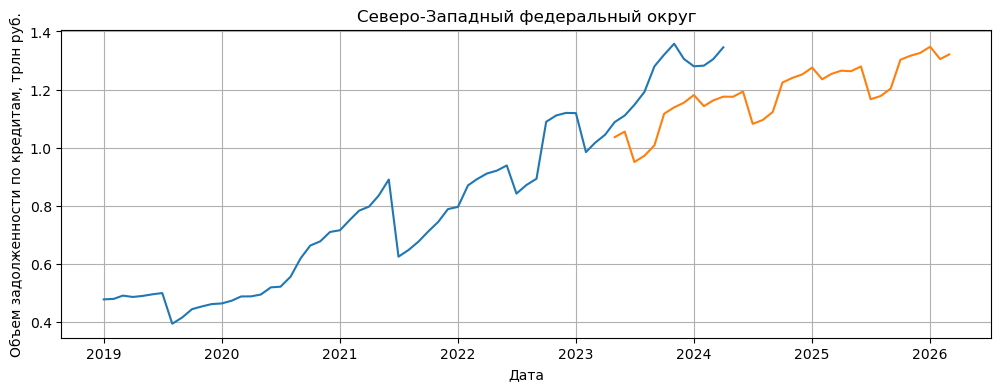

Южный федеральный округ 

Спрогнозированные значения:
2023-05-01    1.050185e+06
2023-06-01    1.092458e+06
2023-07-01    1.107183e+06
2023-08-01    1.141171e+06
2023-09-01    1.184648e+06
2023-10-01    1.209021e+06
2023-11-01    1.237481e+06
2023-12-01    1.284204e+06
2024-01-01    1.308636e+06
2024-02-01    1.348592e+06
2024-03-01    1.417593e+06
2024-04-01    1.466038e+06
2024-05-01    1.496529e+06
2024-06-01    1.550774e+06
2024-07-01    1.577612e+06
2024-08-01    1.623853e+06
2024-09-01    1.679724e+06
2024-10-01    1.716631e+06
2024-11-01    1.757766e+06
2024-12-01    1.817305e+06
2025-01-01    1.854693e+06
2025-02-01    1.907746e+06
2025-03-01    1.989984e+06
2025-04-01    2.051807e+06
2025-05-01    2.095816e+06
2025-06-01    2.163719e+06
2025-07-01    2.204357e+06
2025-08-01    2.264538e+06
2025-09-01    2.334489e+06
2025-10-01    2.385618e+06
2025-11-01    2.441114e+06
2025-12-01    2.515155e+06
2026-01-01    2.567186e+06
2026-02-01    2.635022e+06
2026-03-01    2.732184e+06
F

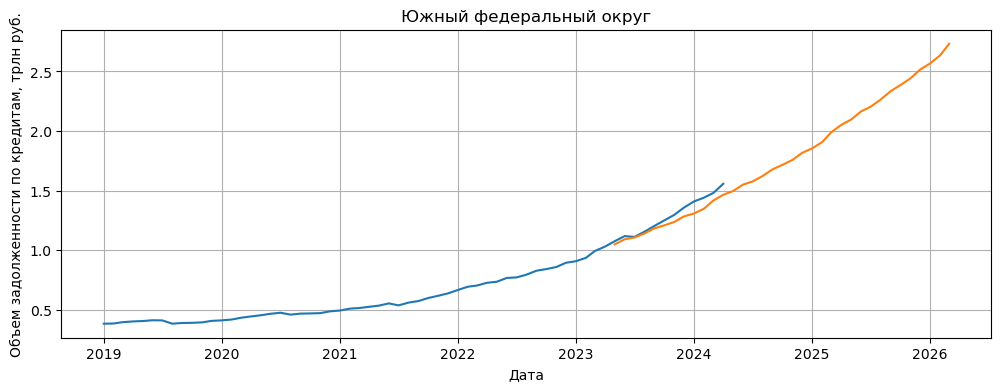

Северо-Кавказский федеральный округ 

Спрогнозированные значения:
2023-05-01    224313.136686
2023-06-01    230923.683477
2023-07-01    227499.642826
2023-08-01    240529.010970
2023-09-01    246967.791326
2023-10-01    254157.982243
2023-11-01    259216.584570
2023-12-01    270175.597213
2024-01-01    275798.021323
2024-02-01    280719.856787
2024-03-01    295169.101776
2024-04-01    302502.759293
2024-05-01    310592.963663
2024-06-01    320297.989273
2024-07-01    320022.838412
2024-08-01    336255.507314
2024-09-01    345951.999398
2024-10-01    356454.313011
2024-11-01    364879.449003
2024-12-01    379259.406280
2025-01-01    388357.185994
2025-02-01    396808.788030
2025-03-01    414842.210561
2025-04-01    425814.456588
2025-05-01    437597.660438
2025-06-01    451050.096497
2025-07-01    454576.767053
2025-08-01    474665.668341
2025-09-01    488272.803780
2025-10-01    502740.171719
2025-11-01    515184.773004
2025-12-01    533638.606544
2026-01-01    546864.673489
2026-02-01

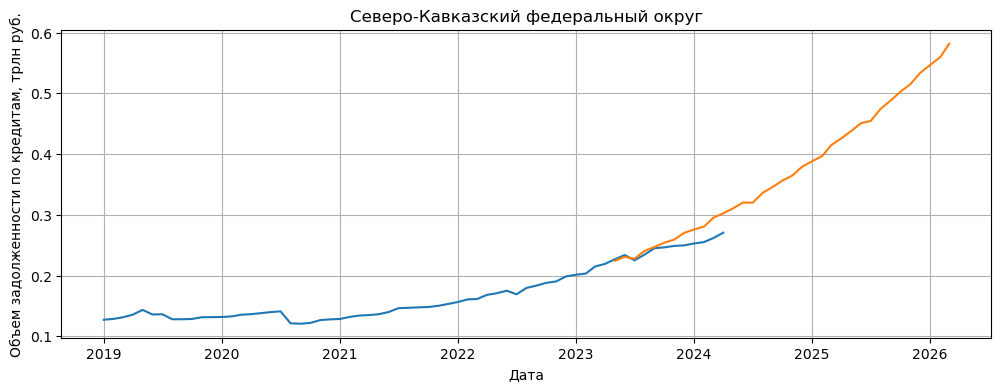

Приволжский федеральный округ 

Спрогнозированные значения:
2023-05-01    1.333503e+06
2023-06-01    1.365640e+06
2023-07-01    1.318852e+06
2023-08-01    1.360322e+06
2023-09-01    1.397765e+06
2023-10-01    1.422749e+06
2023-11-01    1.459563e+06
2023-12-01    1.447518e+06
2024-01-01    1.444626e+06
2024-02-01    1.468868e+06
2024-03-01    1.514502e+06
2024-04-01    1.576010e+06
2024-05-01    1.584700e+06
2024-06-01    1.616610e+06
2024-07-01    1.569423e+06
2024-08-01    1.610323e+06
2024-09-01    1.647024e+06
2024-10-01    1.671096e+06
2024-11-01    1.706827e+06
2024-12-01    1.693527e+06
2025-01-01    1.689210e+06
2025-02-01    1.711854e+06
2025-03-01    1.755720e+06
2025-04-01    1.815288e+06
2025-05-01    1.821867e+06
2025-06-01    1.851495e+06
2025-07-01    1.801855e+06
2025-08-01    1.840130e+06
2025-09-01    1.874036e+06
2025-10-01    1.895141e+06
2025-11-01    1.927733e+06
2025-12-01    1.911124e+06
2026-01-01    1.903326e+06
2026-02-01    1.922319e+06
2026-03-01    1.962362

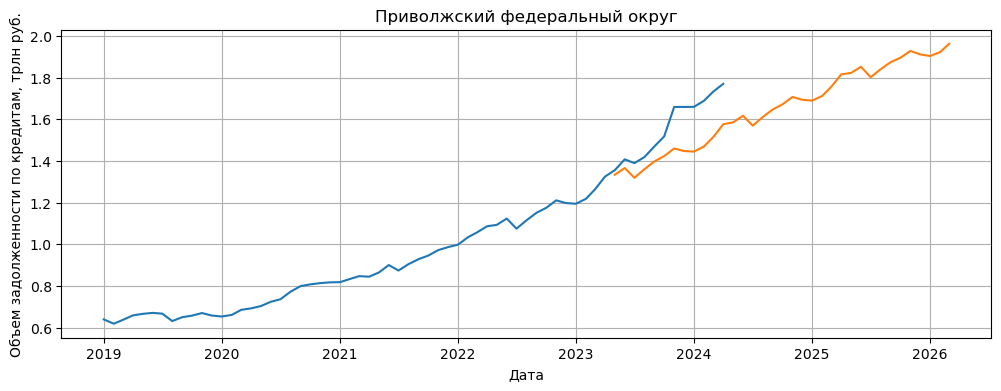

Уральский федеральный округ 

Спрогнозированные значения:
2023-05-01    7.777121e+05
2023-06-01    7.976261e+05
2023-07-01    7.836372e+05
2023-08-01    8.090631e+05
2023-09-01    8.443660e+05
2023-10-01    8.638139e+05
2023-11-01    8.913187e+05
2023-12-01    9.157705e+05
2024-01-01    9.346253e+05
2024-02-01    9.610990e+05
2024-03-01    1.088880e+06
2024-04-01    1.109944e+06
2024-05-01    1.140290e+06
2024-06-01    1.171693e+06
2024-07-01    1.169374e+06
2024-08-01    1.206652e+06
2024-09-01    1.253990e+06
2024-10-01    1.285654e+06
2024-11-01    1.325557e+06
2024-12-01    1.362589e+06
2025-01-01    1.394206e+06
2025-02-01    1.433624e+06
2025-03-01    1.574531e+06
2025-04-01    1.608904e+06
2025-05-01    1.652739e+06
2025-06-01    1.697814e+06
2025-07-01    1.709349e+06
2025-08-01    1.760664e+06
2025-09-01    1.822219e+06
2025-10-01    1.868283e+06
2025-11-01    1.922768e+06
2025-12-01    1.974564e+06
2026-01-01    2.021126e+06
2026-02-01    2.075672e+06
2026-03-01    2.231888e+

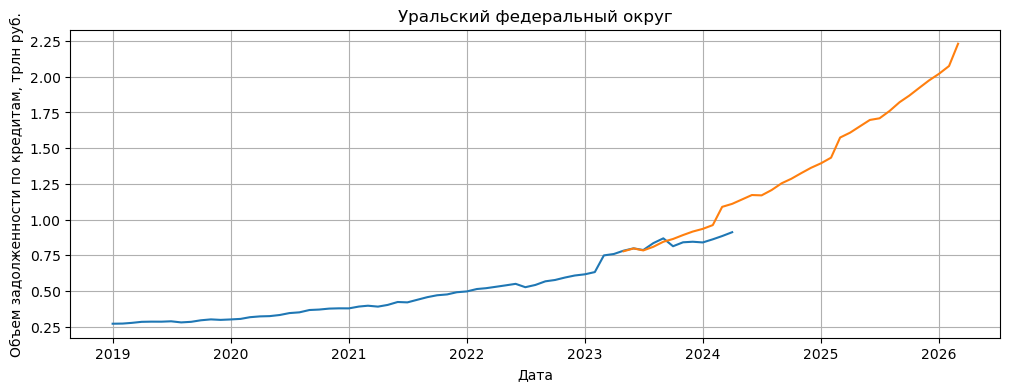

Сибирский федеральный округ 

Спрогнозированные значения:
2023-05-01    8.114598e+05
2023-06-01    8.543310e+05
2023-07-01    8.304629e+05
2023-08-01    8.550483e+05
2023-09-01    8.819442e+05
2023-10-01    8.877167e+05
2023-11-01    9.113328e+05
2023-12-01    9.224793e+05
2024-01-01    9.206885e+05
2024-02-01    9.328332e+05
2024-03-01    9.593954e+05
2024-04-01    9.850152e+05
2024-05-01    1.001441e+06
2024-06-01    1.046634e+06
2024-07-01    1.025068e+06
2024-08-01    1.051934e+06
2024-09-01    1.081090e+06
2024-10-01    1.089103e+06
2024-11-01    1.114939e+06
2024-12-01    1.128284e+06
2025-01-01    1.128672e+06
2025-02-01    1.142975e+06
2025-03-01    1.171675e+06
2025-04-01    1.199412e+06
2025-05-01    1.217935e+06
2025-06-01    1.265205e+06
2025-07-01    1.245694e+06
2025-08-01    1.274596e+06
2025-09-01    1.305768e+06
2025-10-01    1.315775e+06
2025-11-01    1.343585e+06
2025-12-01    1.358884e+06
2026-01-01    1.361205e+06
2026-02-01    1.377421e+06
2026-03-01    1.408013e+

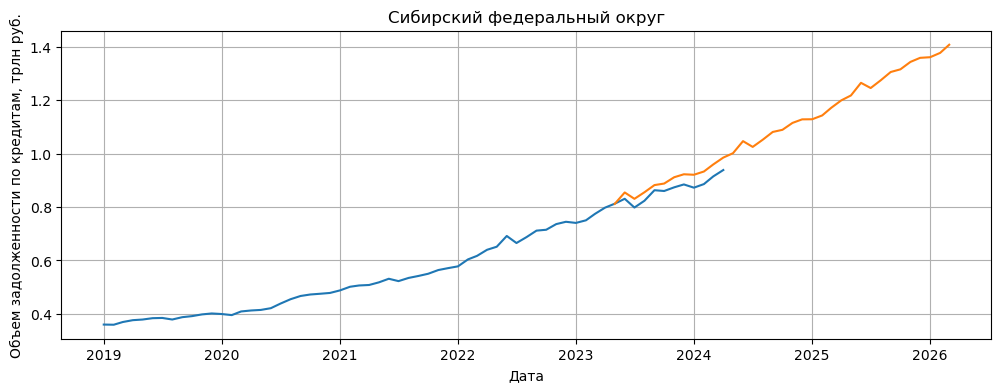

Дальневосточный федеральный округ 

Спрогнозированные значения:
2023-05-01    558441.275688
2023-06-01    569546.322551
2023-07-01    504914.494675
2023-08-01    522445.404771
2023-09-01    545550.553463
2023-10-01    556198.948380
2023-11-01    560203.967137
2023-12-01    593379.948025
2024-01-01    593387.369580
2024-02-01    602143.457385
2024-03-01    619095.895846
2024-04-01    698274.737259
2024-05-01    623414.960325
2024-06-01    633934.926384
2024-07-01    572776.301870
2024-08-01    589121.926893
2024-09-01    610950.620647
2024-10-01    620847.947971
2024-11-01    624907.379412
2024-12-01    656207.404748
2025-01-01    655941.734501
2025-02-01    664490.902643
2025-03-01    681064.749223
2025-04-01    753295.756577
2025-05-01    683514.877125
2025-06-01    693543.721966
2025-07-01    631893.976234
2025-08-01    647748.480038
2025-09-01    669086.052574
2025-10-01    678492.258680
2025-11-01    682060.568902
2025-12-01    712869.473020
2026-01-01    712112.681555
2026-02-01  

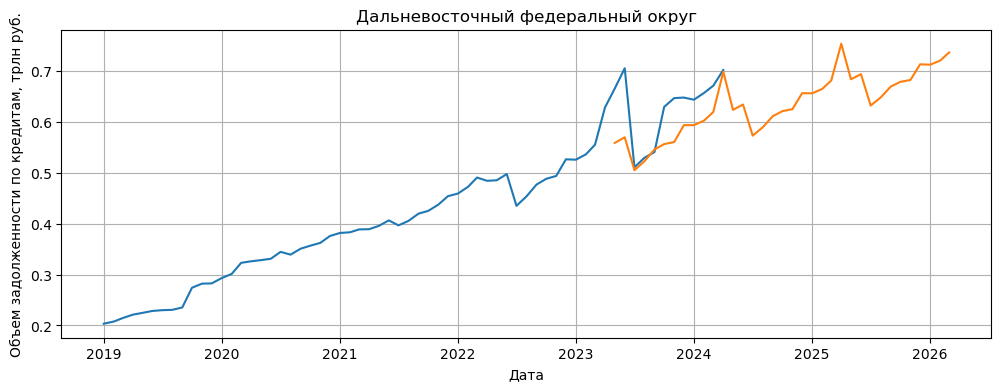

In [9]:
for key,value in regions.items():
    # Берем данные только по федеральным округам
    if key in [23, 42, 55, 64, 72, 87, 95, 106]:
        # получаем данные в формате датафрейма
        loans_volume_reg_df =  get_loans_volume_msp_df(2019, 2024, spikes_remove=False, measure_id=key)
        # определяем дату, до которой возьмем данные для обучения модели
        split_date = '2023-05'
        # определяем дату, до которой определяем прогноз
        last_predict_date = '2026-03'
        # Составляем прогноз
        predict, mp = get_data_predict(loans_volume_reg_df, split_date, last_predict_date)
        print(value, "\n")
        print("Спрогнозированные значения:")
        print(predict)
        print("MAPE = ", mp)
        # визуализируем данные и прогноз по ним
        show_plot(loans_volume_reg_df, predict, 'Объем задолженности по кредитам', value)

# Временной разрез

## Объем кредитов, выданных МСП:

Российская федерация 

Спрогнозированные значения:
2023-05-01    1.038629e+06
2023-06-01    1.326223e+06
2023-07-01    1.230858e+06
2023-08-01    1.259380e+06
2023-09-01    1.391760e+06
2023-10-01    1.428776e+06
2023-11-01    1.338544e+06
2023-12-01    1.744939e+06
2024-01-01    1.148829e+06
2024-02-01    1.312077e+06
2024-03-01    1.492811e+06
2024-04-01    1.448014e+06
2024-05-01    1.330400e+06
2024-06-01    1.619299e+06
2024-07-01    1.568268e+06
2024-08-01    1.608166e+06
2024-09-01    1.748438e+06
2024-10-01    1.786862e+06
2024-11-01    1.682801e+06
2024-12-01    2.092701e+06
2025-01-01    1.481045e+06
2025-02-01    1.646289e+06
2025-03-01    1.932397e+06
2025-04-01    1.878990e+06
2025-05-01    1.767335e+06
2025-06-01    2.064621e+06
2025-07-01    2.002856e+06
2025-08-01    2.046521e+06
2025-09-01    2.192019e+06
2025-10-01    2.238456e+06
2025-11-01    2.149067e+06
2025-12-01    2.565887e+06
2026-01-01    1.969499e+06
2026-02-01    2.142166e+06
2026-03-01    2.389873e+06
Freq

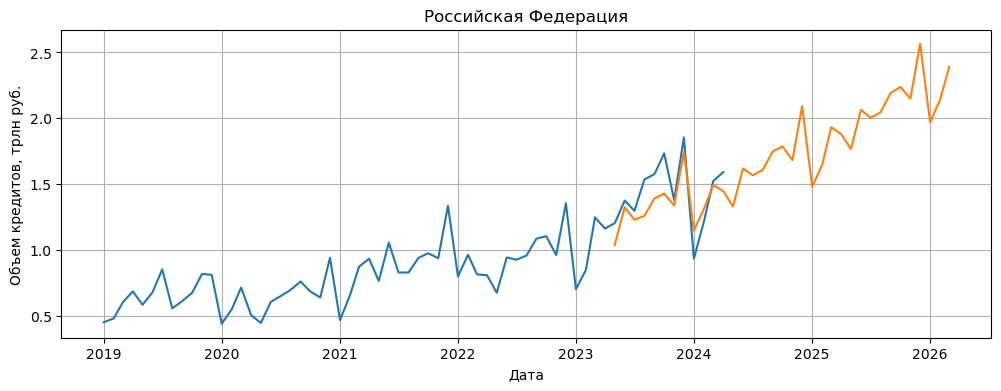

In [18]:
all_new_loans_msp_df =get_new_loans_msp_df(2019, 2024, spikes_remove=False, measure_id=22)

# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-05'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'

# Подбор параметров вручную
s_ord = (1,1,1,12)
pdq = (1,1,1)

# Составляем прогноз
predict, mp = get_data_predict(all_new_loans_msp_df, split_date, last_predict_date, custom = True,  season_ord = s_ord, custom_pdq = pdq )
print("Российская федерация", "\n")
print("Спрогнозированные значения:")
print(predict)
print("MAPE = ", mp)


# визуализируем данные и прогноз по ним
show_plot(all_new_loans_msp_df, predict, 'Объем кредитов')

## Объем задолженности МСП:

Российская федерация 

Спрогнозированные значения:
2023-05-01    1.089059e+07
2023-06-01    1.111365e+07
2023-07-01    1.053190e+07
2023-08-01    1.095011e+07
2023-09-01    1.135916e+07
2023-10-01    1.171636e+07
2023-11-01    1.202713e+07
2023-12-01    1.236514e+07
2024-01-01    1.248968e+07
2024-02-01    1.275593e+07
2024-03-01    1.320120e+07
2024-04-01    1.366386e+07
2024-05-01    1.388569e+07
2024-06-01    1.414282e+07
2024-07-01    1.358079e+07
2024-08-01    1.402199e+07
2024-09-01    1.445982e+07
2024-10-01    1.484779e+07
2024-11-01    1.519389e+07
2024-12-01    1.556204e+07
2025-01-01    1.563373e+07
2025-02-01    1.593149e+07
2025-03-01    1.640419e+07
2025-04-01    1.689051e+07
2025-05-01    1.713690e+07
2025-06-01    1.741515e+07
2025-07-01    1.688713e+07
2025-08-01    1.735798e+07
2025-09-01    1.781864e+07
2025-10-01    1.822634e+07
2025-11-01    1.858655e+07
2025-12-01    1.897274e+07
2026-01-01    1.914246e+07
2026-02-01    1.945461e+07
2026-03-01    1.994451e+07
Freq

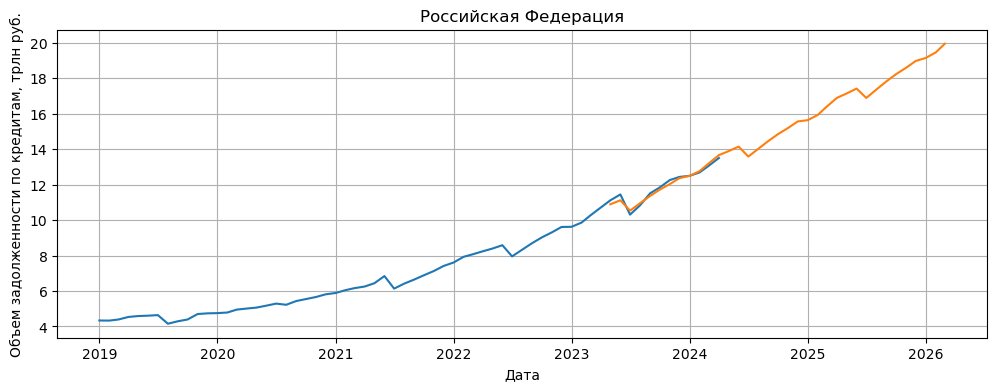

In [20]:
all_loans_msp_df = get_loans_volume_msp_df(2019, 2024, spikes_remove=False)

# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-05'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'

# Подбор параметров вручную
s_ord = (1,1,1,12)
pdq = (1,1,1)

# Составляем прогноз
predict, mp = get_data_predict(all_loans_msp_df, split_date, last_predict_date, custom = True,  season_ord = s_ord, custom_pdq = pdq )
print("Российская федерация", "\n")
print("Спрогнозированные значения:")
print(predict)
print("MAPE = ", mp)


# визуализируем данные и прогноз по ним
show_plot(all_loans_msp_df, predict, 'Объем задолженности по кредитам')